**정부 보도자료 기반 경제정책 불확실지수의 KOSPI 방향 예측 중요도 분석**

**-- 랜덤포레스트를 이용한 클러스터 변수중요도 분석 --**

조정효

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykrx import stock
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

## get data - label

예측하고자 하는 코스피 방향 label을 얻고자, 코스피 가격자료를 다운받자.

In [2]:
#코스피
market= stock.get_index_ohlcv("20140101", "20240601", "1001").iloc[:,:-2]
market.columns = ['open','high','low','close','volume']
market

,open,high,low,close,volume
날짜,,,,,
2014-01-02,2013.11,2013.89,1967.19,1967.19,207769815
2014-01-03,1963.72,1964.63,1936.15,1946.14,188529402
2014-01-06,1947.62,1961.85,1943.74,1953.28,193630493
2014-01-07,1947.65,1965.74,1947.08,1959.44,193026899
2014-01-08,1965.50,1966.95,1950.02,1958.96,217070410
...,...,...,...,...,...
2024-05-27,2697.16,2725.08,2693.66,2722.99,556709910
2024-05-28,2715.52,2730.12,2714.34,2722.85,440956718
2024-05-29,2719.56,2721.63,2677.07,2677.30,438980914


In [3]:
close_price = market['close']
close_price

날짜
2014-01-02    1967.19
2014-01-03    1946.14
2014-01-06    1953.28
2014-01-07    1959.44
2014-01-08    1958.96
               ...   
2024-05-27    2722.99
2024-05-28    2722.85
2024-05-29    2677.30
2024-05-30    2635.44
2024-05-31    2636.52
Name: close, Length: 2561, dtype: float64

## get data - feature1

- ohlcv와 그것의 sma, difference를 사용한다
- 예측에 사용할 feature를 넣기 위해 코스피지수의 시가,고가,저가,종가, 거래량 데이터(OHLCV)를 사용한다.
- OHLCV의 과거 이동평균 수치와 5일 차분 자료를 사용한다.
- 많은 주가지수 예측 ML feature로 해당 자산의 가격,거래량의 과거 추세 및 거래 추세를 사용한다. 이는 모멘텀 전략의 스피릿에 기반하며, 행동주의 금융의 관점이다.
- 정책키워드 feature를 효과적으로 분석하기 위해 이러한 feature를 추가하는것이다

In [4]:
def make_ma_df(df_, window_list):
    df=df_.copy()
    windows_ma=window_list
    for i in df.columns:
        for j in windows_ma:
            df['{} SMA{}'.format(i,j)] = df[i].rolling(j).mean()
            df.dropna(inplace=True)
    out = df.iloc[:,len(df_.T):]
    return out

def make_ret_df(df_):
    df=df_.copy()
    for i in df.columns:
        df['{} %Change'.format(i)] = df[i].pct_change(1)
        df.dropna(inplace=True)
    out = df.iloc[:,len(df_.T):]
    return out

In [5]:
df_ohlcv = market.copy()
df_ma = make_ma_df(df_ohlcv,[5])
df_diff = make_ret_df(df_ohlcv)

In [6]:
df_ma

,open SMA5,high SMA5,low SMA5,close SMA5,volume SMA5
날짜,,,,,
2014-02-03,1922.132,1931.694,1914.292,1925.788,267949037.2
2014-02-04,1912.814,1921.908,1906.500,1915.046,262296807.8
2014-02-05,1911.222,1918.452,1904.242,1911.242,243015875.0
2014-02-06,1909.256,1916.782,1902.902,1909.434,240805004.4
2014-02-07,1908.560,1913.090,1899.978,1905.704,251411199.8
...,...,...,...,...,...
2024-05-27,2713.266,2724.778,2701.288,2716.008,506394192.4
2024-05-28,2709.764,2723.906,2700.208,2715.742,482421739.6
2024-05-29,2708.984,2721.618,2694.048,2706.510,473273146.8


In [7]:
df_diff

,open %Change,high %Change,low %Change,close %Change,volume %Change
날짜,,,,,
2014-01-09,-0.001628,-0.001200,-0.002005,-0.006560,0.273330
2014-01-10,-0.006508,-0.003879,-0.007682,-0.003890,-0.048515
2014-01-13,-0.001103,-0.001482,0.006043,0.005355,0.018820
2014-01-14,-0.002357,0.003920,-0.001812,-0.001462,-0.089119
2014-01-15,0.007021,-0.002493,0.003383,0.003705,0.027878
...,...,...,...,...,...
2024-05-27,0.001303,0.010415,0.004658,0.013168,0.109783
2024-05-28,0.006807,0.001849,0.007677,-0.000051,-0.207924
2024-05-29,0.001488,-0.003110,-0.013731,-0.016729,-0.004481


In [8]:
features = df_ohlcv.join([df_ma, df_diff]).dropna()
features

,open,high,low,close,volume,open SMA5,high SMA5,low SMA5,close SMA5,volume SMA5,open %Change,high %Change,low %Change,close %Change,volume %Change
날짜,,,,,,,,,,,,,,,
2014-02-03,1930.09,1931.81,1917.64,1919.96,229649075,1922.132,1931.694,1914.292,1925.788,267949037.2,0.002160,-0.005099,-0.004092,-0.010916,0.044187
2014-02-04,1894.96,1898.08,1885.53,1886.85,250975580,1912.814,1921.908,1906.500,1915.046,262296807.8,-0.018201,-0.017460,-0.016745,-0.017245,0.092866
2014-02-05,1897.95,1901.40,1888.47,1891.32,244028734,1911.222,1918.452,1904.242,1911.242,243015875.0,0.001578,0.001749,0.001559,0.002369,-0.027679
2014-02-06,1897.35,1910.91,1897.35,1907.89,259440604,1909.256,1916.782,1902.902,1909.434,240805004.4,-0.000316,0.005002,0.004702,0.008761,0.063156
2014-02-07,1922.45,1923.25,1910.90,1922.50,272962006,1908.560,1913.090,1899.978,1905.704,251411199.8,0.013229,0.006458,0.007142,0.007658,0.052118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,2697.16,2725.08,2693.66,2722.99,556709910,2713.266,2724.778,2701.288,2716.008,506394192.4,0.001303,0.010415,0.004658,0.013168,0.109783
2024-05-28,2715.52,2730.12,2714.34,2722.85,440956718,2709.764,2723.906,2700.208,2715.742,482421739.6,0.006807,0.001849,0.007677,-0.000051,-0.207924
2024-05-29,2719.56,2721.63,2677.07,2677.30,438980914,2708.984,2721.618,2694.048,2706.510,473273146.8,0.001488,-0.003110,-0.013731,-0.016729,-0.004481


In [9]:
X_ = features.copy()
X_stats = X_.describe().T
X_stats = X_stats[['mean','std','50%','min','max','count']].round(2)
X_stats

,mean,std,50%,min,max,count
open,2.325630e+03,3.569400e+02,2.249860e+03,1.474450e+03,3.305460e+03,2541.0
high,2.336360e+03,3.593100e+02,2.262520e+03,1.516750e+03,3.316080e+03,2541.0
low,2.311880e+03,3.542800e+02,2.238250e+03,1.439430e+03,3.295440e+03,2541.0
close,2.324310e+03,3.565800e+02,2.248630e+03,1.457640e+03,3.305210e+03,2541.0
volume,5.412124e+08,3.096209e+08,4.440220e+08,1.688331e+08,3.455505e+09,2541.0
open SMA5,2.325030e+03,3.563900e+02,2.248900e+03,1.558180e+03,3.297290e+03,2541.0
high SMA5,2.335760e+03,3.588800e+02,2.261000e+03,1.602720e+03,3.307810e+03,2541.0
low SMA5,2.311300e+03,3.537300e+02,2.232350e+03,1.492820e+03,3.285130e+03,2541.0
close SMA5,2.323740e+03,3.560300e+02,2.246390e+03,1.541480e+03,3.294840e+03,2541.0
volume SMA5,5.410361e+08,2.906959e+08,4.493456e+08,1.892685e+08,2.257983e+09,2541.0


## get data - feature2 

- 이제 중요한 피쳐를 추가한다.
- kdi eiec에 수집된 경제정책자료의 요약글을 기반으로 불확실 관련 키워드 추이를 추출한다.

In [10]:
raw_df = pd.read_excel('../data/epic_data.xlsx', engine='openpyxl')

In [16]:
df = raw_df[['발간처','자료명', '발간일','요약']].sort_values('발간일').reset_index(drop=True)

In [17]:
# 날짜 형식을 datetime 형식으로 변환하는 함수
def convert_to_datetime(date_str):
    # 'yyyy.mm.' 형식인 경우
    if len(date_str) == 8 and date_str[-1] == '.':
        date_str += '01'
    # 'yyyy.mm.dd' 형식이 아니거나, 잘못된 형식인 경우 None 반환
    elif len(date_str) != 10 or not date_str.replace('.', '').isdigit():
        return None

    # 유효하지 않은 일자 확인 및 수정
    try:
        date = pd.to_datetime(date_str, format='%Y.%m.%d', errors='raise')
        # 유효하지 않은 월이나 일을 가진 경우 None 반환
        if date.month == 0 or date.day == 0:
            return None
    except ValueError:
        # 잘못된 날짜는 'yyyy.mm.01'로 수정
        date_str = date_str[:8] + '01'
        try:
            date = pd.to_datetime(date_str, format='%Y.%m.%d')
        except ValueError:
            return None
    return date

# '발간일' 컬럼을 datetime 형식으로 변환
df['발간일'] = df['발간일'].apply(convert_to_datetime)

In [18]:
df

,발간처,자료명,발간일,요약
0,재무부,당면경제안정십오원칙(안),1950-03-04,재무부에서 1950년 3월 생산부흥 계획에 대한 조정과 인프레 극복을 위한 원조물자...
1,경제기획원 종합기획국,긴급경제대책,1961-06-01,경제기획원은 ’61.6.1 ‘긴급경제대책’을 발표하였다.\n\n- 5.16혁명에 따...
2,경제기획원 외자도입국,외자도입운영방침,1961-12-17,경제기획원은 ’61.12.17 ‘외자도입운영방침’을 마련하였다.\n\n- 1962년...
3,경제기획원 종합기획국,당면경제시책 제1부(영세민대책),1962-07-25,경제기획원은 ’62.7.25 ‘당면경제시책 제1부(영세민대책)’을 마련하였다.\n\...
4,경제기획원 종합기획국,당면종합경제시책 제2부,1962-08-10,경제기획원은 ’62.8.10 ‘당면종합경제시책 제2부’를 발표하였다.\n\n- 고용...
...,...,...,...,...
237425,국립해양조사원,"이안류 확인하고, 안전하게 물놀이 즐기세요!",2024-05-31,해양수산부는 여름철에 국민들이 해수욕장에서 안전하게 물놀이를 즐길 수 있도록 전국 ...
237426,과학기술정보통신부 네트워크정책실 정보보호네트워크정책관 디지털기반안전과,"과기정통부, 카카오 연속 장애 시정 요구",2024-05-31,"과학기술정보통신부는 카카오에게 1개월 이내 개선 조치계획을 수립하여 제출하고, 3개..."
237427,과학기술정보통신부 연구개발정책실 거대공공연구정책관 원자력연구협력팀,"과기정통부, 원자력기구(NEA)에서 한국의 역할 확대를 위한 협력방안 논의",2024-05-31,과학기술정보통신부는 5.30.(목) 국가과학기술자문회의 회의실에서 경제협력개발기구 ...
237428,농림축산식품부 방역정책국 방역정책과,제91차 세계동물보건기구(WOAH) 정기총회 참석 결과,2024-06-01,해양수산부와 농림축산식품부는 5.26.(일)~30(목)까지 프랑스 파리에서 개최된 ...


### keyword 카운트

`keyword_count`: KDI 경제정보센터에 수록된 경제정책자료 중, 요약 글에 다음과 같은 키워드가 (or) 방식으로 포함됐을 때, 이를 카운트한다.

1. ['불확실','불확실성',], (EPU)
2. ['불확실성','불확실','위기','위험','리스크','불안','우려','걱정'] (EPU_KR_6 in 이긍희 외(2020))

이때 단순 키워드 포함 자료의 숫자가 아닌 포함 보도자료의 비율(해당 키워드 포함 보도자료 개수/당일 모든 보도자료 개수)로 한다.

이러한 방식은 Baker(2016)의 EPU 지수에 기반하며, 한글 키워드 선정은 이긍희 외(2020)을 참고하였다.

In [39]:
# input
keywords = ['불확실','불확실성']
keywords2 = ['불확실성','불확실','위기','위험','리스크','불안','우려','걱정']
start_date = '2014-01-01'
end_date = '2024-05-31'
period = 'daily'
from_summary = '요약'

### 첫번째 키워드 옵션

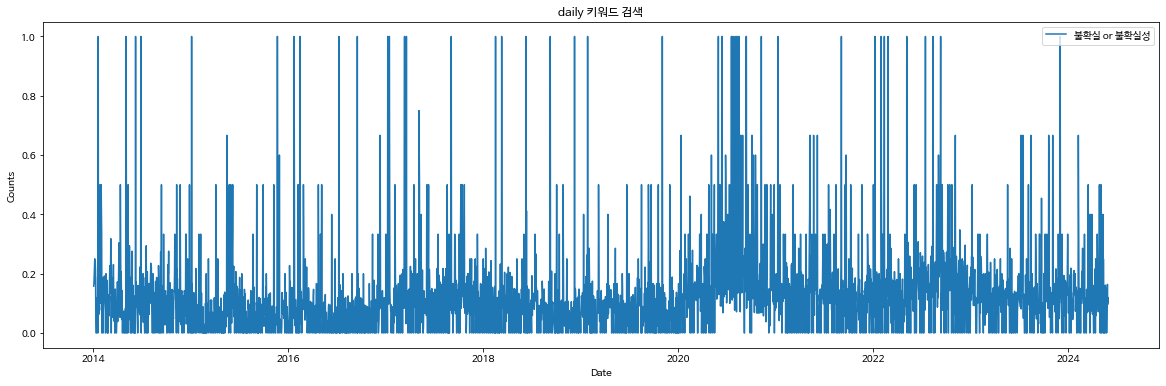

In [40]:
# function
def contains_keyword(text):
    if isinstance(text, str):  # Check if the entry is a string
        return int(any(keyword in text for keyword in keywords))
    return 0  # If not a string, return 0

df_ = df.copy()
# 요약에 포함되어 있는지 여부
df_['포함_요약'] = df_['요약'].apply(contains_keyword)
# 제목에 포함되어 있는지 여부
df_['포함_제목'] = df_['자료명'].apply(contains_keyword)

# count by period
def count_by_period_ratio(data, period, from_summary='요약', start_date='1996-01-01', end_date='2024-05-31'):
    data = data[(data['발간일'] >= start_date) & (data['발간일'] <= end_date)]
    if from_summary == '요약':
        keyword_col = '포함_요약'
    elif from_summary == '제목':
        keyword_col = '포함_제목'

    if period == 'daily':
        counts = data.groupby(data['발간일'].dt.date)[keyword_col].agg(['count', 'sum'])
    elif period == 'monthly':
        counts = data.groupby(data['발간일'].dt.to_period('M'))[keyword_col].agg(['count', 'sum'])
    elif period == 'annually':
        counts = data.groupby(data['발간일'].dt.to_period('Y'))[keyword_col].agg(['count', 'sum'])
    else:
        raise ValueError("Invalid period. Choose from 'daily', 'monthly', or 'annually'.")

    counts.columns = ['total_count', 'keyword_count']
    counts['keyword_ratio'] = counts['keyword_count'] / counts['total_count']
    return counts['keyword_ratio']

# result
result1 = count_by_period_ratio(df_, period=period, from_summary=from_summary, start_date=start_date, end_date=end_date)

# output
plt.figure(figsize=(20, 6))
result.plot()
plt.title(f'{period} 키워드 검색')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.legend([" or ".join(keywords)])
plt.show()

### 두번째 키워드 옵션

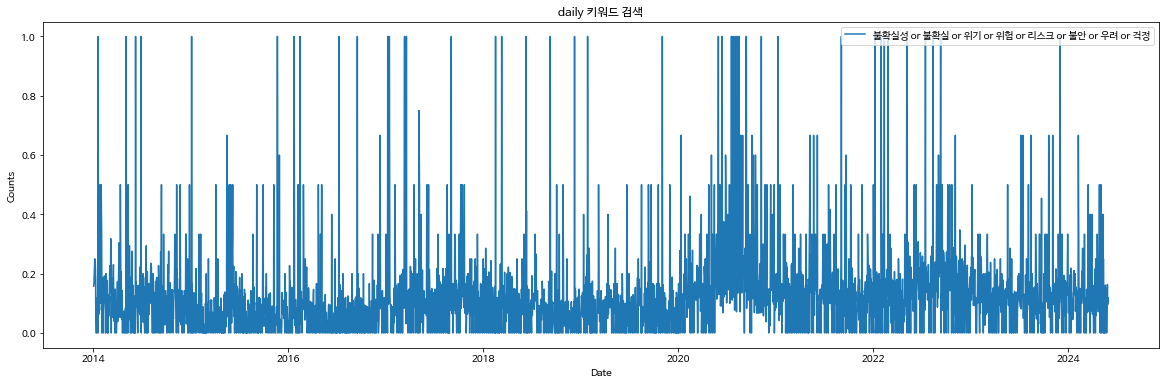

In [41]:
# function
def contains_keyword2(text):
    if isinstance(text, str):  # Check if the entry is a string
        return int(any(keyword in text for keyword in keywords2))
    return 0  # If not a string, return 0

df_ = df.copy()

# 요약에 포함되어 있는지 여부
df_['포함_요약'] = df_['요약'].apply(contains_keyword2)
# 제목에 포함되어 있는지 여부
df_['포함_제목'] = df_['자료명'].apply(contains_keyword2)

# count by period
def count_by_period_ratio(data, period, from_summary='요약', start_date='1996-01-01', end_date='2024-05-31'):
    data = data[(data['발간일'] >= start_date) & (data['발간일'] <= end_date)]
    if from_summary == '요약':
        keyword_col = '포함_요약'
    elif from_summary == '제목':
        keyword_col = '포함_제목'

    if period == 'daily':
        counts = data.groupby(data['발간일'].dt.date)[keyword_col].agg(['count', 'sum'])
    elif period == 'monthly':
        counts = data.groupby(data['발간일'].dt.to_period('M'))[keyword_col].agg(['count', 'sum'])
    elif period == 'annually':
        counts = data.groupby(data['발간일'].dt.to_period('Y'))[keyword_col].agg(['count', 'sum'])
    else:
        raise ValueError("Invalid period. Choose from 'daily', 'monthly', or 'annually'.")

    counts.columns = ['total_count', 'keyword_count']
    counts['keyword_ratio'] = counts['keyword_count'] / counts['total_count']
    return counts['keyword_ratio']

# result
result2 = count_by_period_ratio(df_, period=period, from_summary=from_summary, start_date=start_date, end_date=end_date)

# output
plt.figure(figsize=(20, 6))
result.plot()
plt.title(f'{period} 키워드 검색')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.legend([" or ".join(keywords2)])
plt.show()

## Feature preprocessing

이제 생성한 feauture의 전처리를 해보자. standard scaling을 이용하되 training set만을 fit한다.

우선 키워드는 키워드옵션1을 사용한다.

### scaling

In [43]:
# Feature Importance / Clustering
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

In [44]:
from sklearn.preprocessing import StandardScaler

def feature_scaler(X):
    X_sc = StandardScaler().fit_transform(X)
    X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)
    return X_sc

In [45]:
X = X_.join(result1).dropna()
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2540 entries, 2014-02-03 to 2024-05-31
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open            2540 non-null   float64
 1   high            2540 non-null   float64
 2   low             2540 non-null   float64
 3   close           2540 non-null   float64
 4   volume          2540 non-null   int64  
 5   open SMA5       2540 non-null   float64
 6   high SMA5       2540 non-null   float64
 7   low SMA5        2540 non-null   float64
 8   close SMA5      2540 non-null   float64
 9   volume SMA5     2540 non-null   float64
 10  open %Change    2540 non-null   float64
 11  high %Change    2540 non-null   float64
 12  low %Change     2540 non-null   float64
 13  close %Change   2540 non-null   float64
 14  volume %Change  2540 non-null   float64
 15  keyword_ratio   2540 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 337.3 KB


### Clustering

클러스터링은 중요도 분석을 위해 해둔다.

같은 클러스터에 묶일 경우 데이터간 거리가 가까운 feature이다. 따라서 중요도 분석 시 robustness를 방해한다. 따라서 중요도 분석은 클러스터에 대해 한다.

hierachical clustering 사용 <== 덴도그램을 보고 효과적으로 클러스터를 구분할 수 있다.

{1: ['open',
  'high',
  'low',
  'close',
  'open SMA5',
  'high SMA5',
  'low SMA5',
  'close SMA5'],
 2: ['volume', 'volume SMA5'],
 3: ['high %Change', 'low %Change', 'close %Change'],
 4: ['open %Change'],
 5: ['volume %Change'],
 6: ['keyword_ratio']}

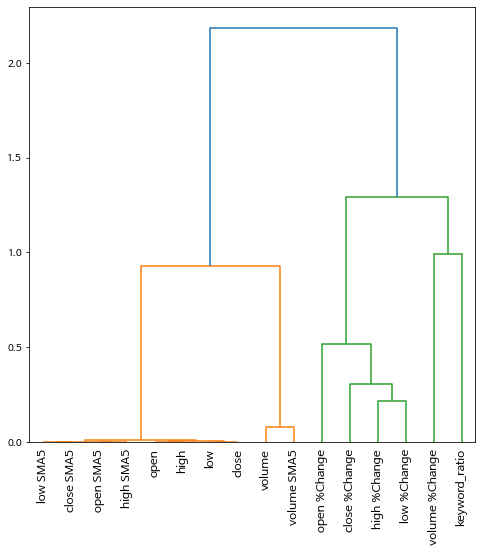

In [46]:
fig, ax = plt.subplots(1, figsize=(8, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns, ax=ax, leaf_rotation=90
)

from collections import defaultdict
cluster_ids = hierarchy.fcluster(dist_linkage, 0.5, criterion="distance")
clusters_ = {i: X.columns[np.where(cluster_ids == i)[0]].tolist() for i in np.unique(cluster_ids)}
clusters_

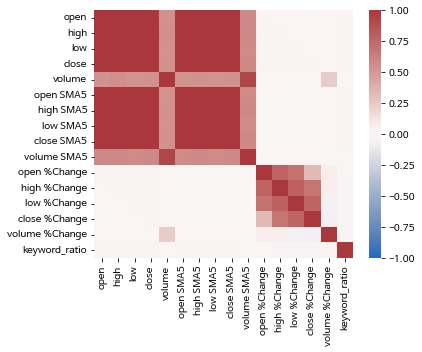

In [47]:
plt.figure(figsize=(6,5))
sns.heatmap(X.corr(), vmin=-1,vmax=1, cmap='vlag')
plt.tight_layout()
plt.show()

## Model

In [48]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score

### 모델 정의 및 라벨링

Logistic Regression과 Random Forest사용

Label(예측 하고자하는 값)은 코스피 종가의 1일 후 방향, 5일 후 방향, 20일 후 방향으로 설정한다.

In [49]:
rf = RandomForestClassifier(max_depth=3, n_estimators=100)
lr = LogisticRegression()
clf_list = [[lr,rf],[lr,rf],[lr,rf]]
estimators=['LR','RF']

# 시기별 labeling
periods = [1,5,20]
y_list = [np.sign(np.sign(-close_price.diff(-y_))+1).rename('y_{}'.format(y_)) for y_ in periods]

In [50]:
def simple_train_test_split(X_,y_,start_date, split_date, end_date):
    tmp = pd.concat([X_,y_],axis=1).dropna()
    X = tmp.iloc[:,:-1]; y = tmp.iloc[:,-1].rename('y')
    X_train = X[start_date:split_date]; y_train = y[start_date:split_date]
    X_test = X[split_date:end_date]; y_test = y[split_date:end_date]; 
    return X_train, y_train, X_test, y_test

In [51]:
def feature_scaler_test(X_train, X_test):
    scaler = StandardScaler()
    X_sc_train = scaler.fit_transform(X_train)
    X_sc_test = scaler.transform(X_test)
    X_sc_test = pd.DataFrame(X_sc_test, index=X_test.index, columns=X_test.columns)
    return X_sc_test

### Run 모델

In [52]:
results_list=[]

for i in range(len(y_list)):
    y_i = y_list[i]
    X_train_, y_train, X_test_, y_test = simple_train_test_split(X,y_i,'2014','2022','2024')
    X_train = feature_scaler(X_train_)
    X_test = feature_scaler_test(X_train_, X_test_)
    scores_list = []
    for clf in clf_list[i]:
        y_preds_ = []
        y_probs_ = []
        clf.fit(X_train, y_train)
        y_true = y_test
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:,1]
        
        accs = accuracy_score(y_true, y_pred)
        f1=f1_score(y_true, y_pred)
        #prec=precision_score(y_true, y_pred)
        rocauc = roc_auc_score(y_true, y_prob)
        score = [accs, f1, rocauc]
        scores_list.append(score)
        
    results = pd.DataFrame(scores_list, columns=['accuracy','f1 score','roc auc score'],
                           index=estimators)
    results_list.append(results)

In [53]:
results_df = pd.concat(results_list)
index_array = [np.sort(np.array(['$y_{001}$','$y_{005}$','$y_{020}$']*len(estimators))),np.array(results_df.index.values)]
results_df.index = index_array
results_df.round(4)

accuracy  f1 score  roc auc score
$y_{001}$ LR    0.5135    0.5752         0.5230
          RF    0.5338    0.6145         0.5595
$y_{005}$ LR    0.5204    0.5300         0.5465
          RF    0.5663    0.5799         0.5936
$y_{020}$ LR    0.5916    0.4608         0.6557
          RF    0.6283    0.4792         0.6266

## Feature importance 보기 

- cluster variable importance 사용
- keyword가 속한 클러스터의 중요도를 확인해보자

In [56]:
def clustered_permutation_importance(clf,X,y,clusters,scoring, n_repeats): 
    """
    clf: fitted classifier
    X
    y
    clusters: (dict)
    scoring: 'acc','f1','auc'
    """
    from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

    scr_before, scr_after = pd.Series(), pd.DataFrame(columns=clusters.keys()) 
    for i in range(n_repeats):
        prob=clf.predict_proba(X)[:,1]
        pred=clf.predict(X)
        if scoring == 'auc':
            scr_before.loc[i]=roc_auc_score(y, prob)
        elif scoring == 'f1':
            scr_before.loc[i]=f1_score(y, pred)
        elif scoring == 'acc':
            scr_before.loc[i]=accuracy_score(y, pred)
            
        for  j  in  scr_after.columns:
            X_=X.copy(deep=True) 
            for  k  in  clusters[j]:
                np.random.shuffle(X_[k].values)  #  shufﬂe  cluster 
            prob2=clf.predict_proba(X_)[:,1]
            pred2=clf.predict(X_)
            if scoring == 'auc':
                scr_after.loc[i,j]=roc_auc_score(y, prob2)
            elif scoring == 'acc':
                scr_after.loc[i,j]=accuracy_score(y, pred2)
            elif scoring == 'f1':
                scr_after.loc[i,j]=f1_score(y, pred2)
    imp=(-1*scr_after).add(scr_before,axis=0)
    imp=imp/(1-scr_after).replace(0, np.nan)
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1)
    imp.index = ['Cluster {}'.format(j) for j in scr_after.columns]
    imp.replace([-np.inf, np.nan], 0, inplace=True)
    return  imp

In [57]:
results_list=[]
importance_list_acc = []
importance_list_f1 = []
importance_list_auc = []

for i in range(len(y_list)):
    y_i = y_list[i]
    X_train_, y_train, X_test_, y_test = simple_train_test_split(X,y_i,'2014','2022','2024')
    X_train = feature_scaler(X_train_)
    X_test = feature_scaler_test(X_train_, X_test_)
    scores_list = []
    importance_clf_acc = []
    importance_clf_f1 = []
    importance_clf_auc = []
    for clf in clf_list[i]:
        y_preds_ = []
        y_probs_ = []
        clf.fit(X_train, y_train)
        y_true = y_test
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:,1]
        accs = accuracy_score(y_true, y_pred)
        f1=f1_score(y_true, y_pred)
        prec=precision_score(y_true, y_pred)
        rocauc = roc_auc_score(y_true, y_prob)
        score = [accs, f1, prec, rocauc]
        scores_list.append(score)
        result_imp_acc = clustered_permutation_importance(clf, X_test, y_test, clusters_, 'acc',10)
        result_imp_f1 = clustered_permutation_importance(clf, X_test, y_test, clusters_, 'f1',10)
        result_imp_auc = clustered_permutation_importance(clf, X_test, y_test, clusters_, 'auc',10)
        importance_clf_acc.append(result_imp_acc)
        importance_clf_f1.append(result_imp_f1)
        importance_clf_auc.append(result_imp_auc)
        
    results = pd.DataFrame(scores_list, columns=['accuracy','f1 score','precision score','roc auc score'],
                           index=estimators)
    results_list.append(results)
    importance_list_acc.append(importance_clf_acc)
    importance_list_f1.append(importance_clf_f1)
    importance_list_auc.append(importance_clf_auc)

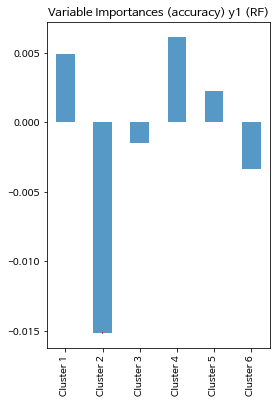

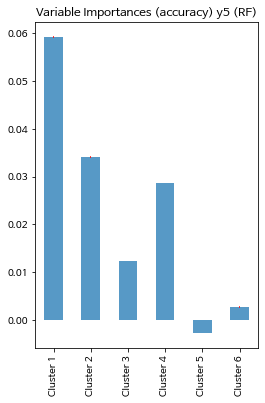

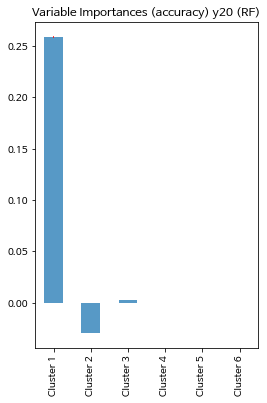

In [58]:
importance_df_acc = []
for j in range(len(y_list)):
    for i in range(len(estimators)-1):
        importance_df = importance_list_acc[j][i+1]
        plt.figure(figsize=(4, 6))
        #importance_df.sort_values('mean', ascending=True, inplace=True)
        importance_df['mean'].plot(kind='bar', alpha=0.75, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
        importance_df_acc.append(importance_df)
        plt.title("Variable Importances (accuracy) y{} ({})".format(periods[j], estimators[i+1]))

## 두번째 키워드 옵션 사용

In [59]:
X = X_.join(result2).dropna()

{1: ['open',
  'high',
  'low',
  'close',
  'open SMA5',
  'high SMA5',
  'low SMA5',
  'close SMA5'],
 2: ['volume', 'volume SMA5'],
 3: ['keyword_ratio'],
 4: ['high %Change', 'low %Change', 'close %Change'],
 5: ['open %Change'],
 6: ['volume %Change']}

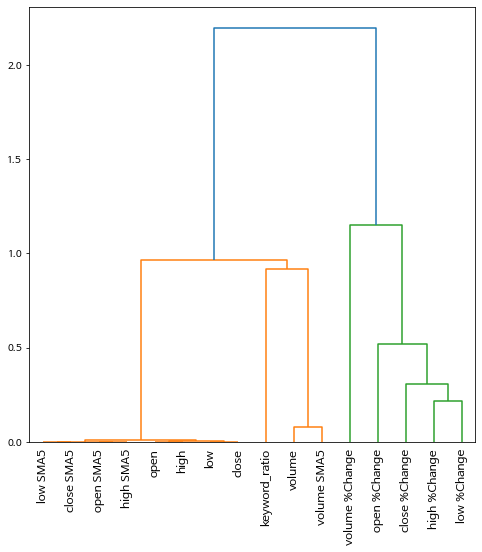

In [61]:
fig, ax = plt.subplots(1, figsize=(8, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns, ax=ax, leaf_rotation=90
)

from collections import defaultdict
cluster_ids = hierarchy.fcluster(dist_linkage, 0.5, criterion="distance")
clusters_ = {i: X.columns[np.where(cluster_ids == i)[0]].tolist() for i in np.unique(cluster_ids)}
clusters_

In [62]:
rf = RandomForestClassifier(max_depth=3, n_estimators=100)
lr = LogisticRegression()
clf_list = [[lr,rf],[lr,rf],[lr,rf]]
estimators=['LR','RF']

# 시기별 labeling
periods = [1,5,20]
y_list = [np.sign(np.sign(-close_price.diff(-y_))+1).rename('y_{}'.format(y_)) for y_ in periods]

In [63]:
results_list=[]

for i in range(len(y_list)):
    y_i = y_list[i]
    X_train_, y_train, X_test_, y_test = simple_train_test_split(X,y_i,'2014','2022','2024')
    X_train = feature_scaler(X_train_)
    X_test = feature_scaler_test(X_train_, X_test_)
    scores_list = []
    for clf in clf_list[i]:
        y_preds_ = []
        y_probs_ = []
        clf.fit(X_train, y_train)
        y_true = y_test
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:,1]
        
        accs = accuracy_score(y_true, y_pred)
        f1=f1_score(y_true, y_pred)
        #prec=precision_score(y_true, y_pred)
        rocauc = roc_auc_score(y_true, y_prob)
        score = [accs, f1, rocauc]
        scores_list.append(score)
        
    results = pd.DataFrame(scores_list, columns=['accuracy','f1 score','roc auc score'],
                           index=estimators)
    results_list.append(results)

In [64]:
results_df = pd.concat(results_list)
index_array = [np.sort(np.array(['$y_{001}$','$y_{005}$','$y_{020}$']*len(estimators))),np.array(results_df.index.values)]
results_df.index = index_array
results_df.round(4)

accuracy  f1 score  roc auc score
$y_{001}$ LR    0.5118    0.5719         0.5280
          RF    0.5152    0.6353         0.5614
$y_{005}$ LR    0.5493    0.5774         0.5537
          RF    0.5697    0.5818         0.5940
$y_{020}$ LR    0.6003    0.4561         0.6607
          RF    0.6265    0.4806         0.6359

### Feature importance 

In [65]:
def clustered_permutation_importance(clf,X,y,clusters,scoring, n_repeats): 
    """
    clf: fitted classifier
    X
    y
    clusters: (dict)
    scoring: 'acc','f1','auc'
    """
    from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

    scr_before, scr_after = pd.Series(), pd.DataFrame(columns=clusters.keys()) 
    for i in range(n_repeats):
        prob=clf.predict_proba(X)[:,1]
        pred=clf.predict(X)
        if scoring == 'auc':
            scr_before.loc[i]=roc_auc_score(y, prob)
        elif scoring == 'f1':
            scr_before.loc[i]=f1_score(y, pred)
        elif scoring == 'acc':
            scr_before.loc[i]=accuracy_score(y, pred)
            
        for  j  in  scr_after.columns:
            X_=X.copy(deep=True) 
            for  k  in  clusters[j]:
                np.random.shuffle(X_[k].values)  #  shufﬂe  cluster 
            prob2=clf.predict_proba(X_)[:,1]
            pred2=clf.predict(X_)
            if scoring == 'auc':
                scr_after.loc[i,j]=roc_auc_score(y, prob2)
            elif scoring == 'acc':
                scr_after.loc[i,j]=accuracy_score(y, pred2)
            elif scoring == 'f1':
                scr_after.loc[i,j]=f1_score(y, pred2)
    imp=(-1*scr_after).add(scr_before,axis=0)
    imp=imp/(1-scr_after).replace(0, np.nan)
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1)
    imp.index = ['Cluster {}'.format(j) for j in scr_after.columns]
    imp.replace([-np.inf, np.nan], 0, inplace=True)
    return  imp

In [66]:
results_list=[]
importance_list_acc = []
importance_list_f1 = []
importance_list_auc = []

for i in range(len(y_list)):
    y_i = y_list[i]
    X_train_, y_train, X_test_, y_test = simple_train_test_split(X,y_i,'2014','2022','2024')
    X_train = feature_scaler(X_train_)
    X_test = feature_scaler_test(X_train_, X_test_)
    scores_list = []
    importance_clf_acc = []
    importance_clf_f1 = []
    importance_clf_auc = []
    for clf in clf_list[i]:
        y_preds_ = []
        y_probs_ = []
        clf.fit(X_train, y_train)
        y_true = y_test
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:,1]
        accs = accuracy_score(y_true, y_pred)
        f1=f1_score(y_true, y_pred)
        prec=precision_score(y_true, y_pred)
        rocauc = roc_auc_score(y_true, y_prob)
        score = [accs, f1, prec, rocauc]
        scores_list.append(score)
        result_imp_acc = clustered_permutation_importance(clf, X_test, y_test, clusters_, 'acc',10)
        result_imp_f1 = clustered_permutation_importance(clf, X_test, y_test, clusters_, 'f1',10)
        result_imp_auc = clustered_permutation_importance(clf, X_test, y_test, clusters_, 'auc',10)
        importance_clf_acc.append(result_imp_acc)
        importance_clf_f1.append(result_imp_f1)
        importance_clf_auc.append(result_imp_auc)
        
    results = pd.DataFrame(scores_list, columns=['accuracy','f1 score','precision score','roc auc score'],
                           index=estimators)
    results_list.append(results)
    importance_list_acc.append(importance_clf_acc)
    importance_list_f1.append(importance_clf_f1)
    importance_list_auc.append(importance_clf_auc)

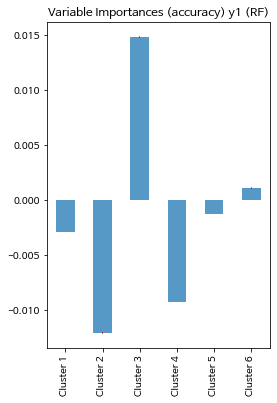

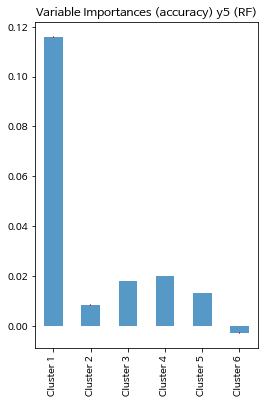

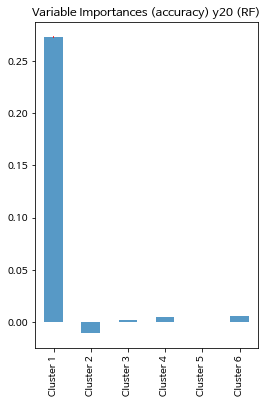

In [67]:
importance_df_acc = []
for j in range(len(y_list)):
    for i in range(len(estimators)-1):
        importance_df = importance_list_acc[j][i+1]
        plt.figure(figsize=(4, 6))
        #importance_df.sort_values('mean', ascending=True, inplace=True)
        importance_df['mean'].plot(kind='bar', alpha=0.75, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
        importance_df_acc.append(importance_df)
        plt.title("Variable Importances (accuracy) y{} ({})".format(periods[j], estimators[i+1]))

# 결론

키워드 옵션 2 2. ['불확실성','불확실','위기','위험','리스크','불안','우려','걱정'] (EPU_KR_6 in 이긍희 외(2020)) 포함 기반의

경제정책 불확실정도 (일별 키워드 포함 자료수/일별 자료수)는,

단기 KOSPI 방향 예측에 가장 큰 중요도를 보인다!

다만, 키워드옵션1['불확실성','불확실']은 매우 낮은 중요도를 보인다.

## 한계점

**한계점**으로는 키워드 추출 시, **한국어 토큰화**가 이루어지지 않은 점이 있다. 또한 단순 단어 포함이기에 **의미적 키워드 추출이 불가**하였다.

또한 **자료 수**가 적다. (일별 자료수가 애초에 많지 않다.) --> 월별로 하면 불확실도가 더 잘 나오지만, 전체 데이터 수(length)가 짧아 ML 분석에 용이하지 못하다.

# References

- 이긍희, 조주희, & 조진경. (2020). 새로운 우리나라 불확실성 지수의 작성. 응용통계연구, 33(5), 639-653.
- 조정효 (2022). KOSPI 방향 예측에 대한 랜덤포레스트 기반 군집화 변수중요도 분석